In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import importlib as lib
from tqdm import tqdm
from data_processing import load_sort_data, transform
from EDA import find_mean_img, eigenimages, plot_pca
import matplotlib.pyplot as plt
%matplotlib inline


# Introduction
The project we are presenting is a multi-label image classification task based on the 2018 Human vs Machine skin lesion analysis toward melanoma detection hosted by the International Skin Imaging Collaboration (ISIC).

This notebook will contain the following sections:
 1. Problem Definition & Data Description
 2. Data Preparation
 3. Exploratory Analysis
 4. Data Processing for Model Ingestion
 5. Model Creation
 6. Model Scoring & Evaluation
 7. Interpretation of Results

# 1. Problem Definition & Data description

#### Problem Definition:
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. With a sufficiently large and diverse collection of skin lesions we will develop a method to automate the prediction of disease classification within dermoscopic images. The project is meant to human computer computer collaboration and not intended to replace traditional forms of diagnosis.  

Possible disease categories (and abbreviation) for classification are:
 1. Melanoma (mel)
 2. Melanocytic Nevus (nv)
 3. Basal Cell Carcinoma (bcc)
 4. Actinic Keratosis / Bowen's Disease (akiec)
 5. Benign Keratosis (bkl)
 6. Dermatofibroma (df)
 7. Vascular Lesion (vasc)

#### Data Description
- Data images are in JPEG format using the naming scheme `ISIC_.jpg` where _ is a 7 digit unique identifier of the image.
- There are a total of 10,015 600x450 pixel color images contained in the training data folder.
- There are a total of 193 600x450 pixel color images contained in the validation data folder.
- The training metadata is a 10,015x8 .csv file containing the following variables*:
  - lesion_id: Unique identifier of a legion with multiple images.
  - image_id: Unique identifier of the associated image file.
  - dx: Prediction label containing the 7 abbreviated disease categories.
  - dx_type: Method of how the diagnosis was confirmed. 
  - age: Numeric year age of the patient.
  - sex: String binary value 'male' or 'female'.
  - localization: Categorical location on the body the image was taken. 
  - dataset: Image source.

*Further details of the data will be provided in the data preparation section.

# 2. Data Preparation

#### Step 1. Load and Sort
First we will load the data using the function `load_sort_data()`.

The `load_sort_data()` function sorts the images into folders based on the diagnosis label.  This will help reduce the overall size of the dataset and make preprocessing the images much faster.  The function will return the metadata as a pandas DataFrame and the path of the sorted image folders. 

In [2]:
# function takes 3 parameters: metadata filename, the folder of the raw images, and the desired name of the destination directory. 
metadata, dest_dir = load_sort_data('HAM10000_metadata', 'ISIC2018_Task3_Training_Input', 'Training_Images_')

100%|██████████| 7/7 [03:32<00:00, 30.35s/it]


In [3]:
# The path of our training image folders sorted by label
dest_dir

'h:\\School\\Winter 2022\\DS Projects\\2018\\hvm-image-clf/data/Training_Images_'

#### Step 2. Tidy Metadata
We will now take steps to tidy our metadata.
First, subset the variables we intend on using, next analyze missingness and finally we will correct our expected datatypes.

In [4]:
# Subsetting into variables we will use. 
metadata = metadata[['image_id', 'dx', 'age', 'sex', 'localization']]
# We will need to change the Dtypes of the columns into the expected types
metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_id      10015 non-null  object 
 1   dx            10015 non-null  object 
 2   age           9958 non-null   float64
 3   sex           10015 non-null  object 
 4   localization  10015 non-null  object 
dtypes: float64(1), object(4)
memory usage: 391.3+ KB


As we can see below, we have a total of 57 NA values in age.  When looking at the distribution of NA values, only our largest quantity of labels have NA's. The age variable is only useful in providing context to our problem and will not be used as a feature in our model.  Therefore it is not necessary to do anything further to the NA values.  During exploratory analysis we can deal with the NA values as needed.

In [5]:
# Sum the na values contained within each label
print("Total number of unique labels\n",
      metadata['dx'].value_counts(), 
      "\nNumber of NaN values within each label\n",
      metadata.drop('dx',1).isna().groupby(
          metadata.dx, 
          dropna=False, 
          observed = True
          ).sum().reset_index()
      );

Total number of unique labels
 nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64 
Number of NaN values within each label
       dx  image_id  age  sex  localization
0  akiec         0    0    0             0
1    bcc         0    0    0             0
2    bkl         0   10    0             0
3     df         0    0    0             0
4    mel         0    2    0             0
5     nv         0   45    0             0
6   vasc         0    0    0             0


<ipython-input-5-f268d13f0828>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  metadata.drop('dx',1).isna().groupby(


In [6]:
#Changing datatypes
dtypes = {'image_id':'string', 
          'dx':'category', 
          'sex':'category',
          'localization': 'category'
          }
metadata = metadata.astype(dtypes)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_id      10015 non-null  string  
 1   dx            10015 non-null  category
 2   age           9958 non-null   float64 
 3   sex           10015 non-null  category
 4   localization  10015 non-null  category
dtypes: category(3), float64(1), string(1)
memory usage: 187.1 KB


#### Step 3. Image Processing

In this step we will construct an NxM matrix where N is an image and M is the number of pixels in the image. 

In [72]:
#Assign vectorized images to variables
akiec_images = transform(dest_dir + 'akiec')

100%|██████████| 327/327 [00:02<00:00, 139.03it/s]


In [73]:
bcc_images = transform(dest_dir + 'bcc')

100%|██████████| 514/514 [00:06<00:00, 76.53it/s] 


In [74]:
bkl_images = transform(dest_dir + 'bkl')

100%|██████████| 1099/1099 [00:21<00:00, 51.53it/s]


In [75]:
df_images = transform(dest_dir + 'df')

100%|██████████| 115/115 [00:01<00:00, 111.11it/s]


In [76]:
mel_images = transform(dest_dir + 'mel')

100%|██████████| 1113/1113 [00:21<00:00, 50.65it/s]


In [77]:
#This takes a really long time to run even when cutting down the images size.
nv_images = transform(dest_dir + 'nv')

100%|██████████| 6705/6705 [08:49<00:00, 12.65it/s]


In [78]:
vasc_images = transform(dest_dir + 'vasc')

100%|██████████| 142/142 [00:01<00:00, 103.95it/s]


In [37]:
akiec_images

array([[168., 164., 163., ..., 141., 140., 139.],
       [139., 145., 146., ..., 160., 160., 160.],
       [171., 174., 172., ..., 184., 188., 189.],
       ...,
       [104., 101.,  98., ...,  34.,  31.,  29.],
       [ 84.,  84.,  88., ...,  10.,   8.,   9.],
       [157., 157., 154., ..., 156., 157., 155.]], dtype=float32)

# 3. Exploratory Data Analysis

Exploratory analysis will be conducted on in two major steps.  First we will complete analysis on the metadata then the image dataset.  

#### Step 1: Metadata EDA
We will perform the following analysis on the metadata:
- Summary Statistics
- Class label distributions
- Correlation

Summary Statistics

In [28]:
metadata.head()

image_id   dx   age   sex localization
0  ISIC_0027419  bkl  80.0  male        scalp
1  ISIC_0025030  bkl  80.0  male        scalp
2  ISIC_0026769  bkl  80.0  male        scalp
3  ISIC_0025661  bkl  80.0  male        scalp
4  ISIC_0031633  bkl  75.0  male          ear

In [29]:
metadata.agg({
    "age":["min", "max", "median", "mean", "skew"]    
})

age
min      0.000000
max     85.000000
median  50.000000
mean    51.863828
skew    -0.166802

In [30]:
metadata.groupby("sex")["sex"].count()

sex
female     4552
male       5406
unknown      57
Name: sex, dtype: int64

Class Label Distributions

Distributions for metadata including Age, Localization, Sex, and Diagnosis

Text(0.5, 1.0, 'Localization')

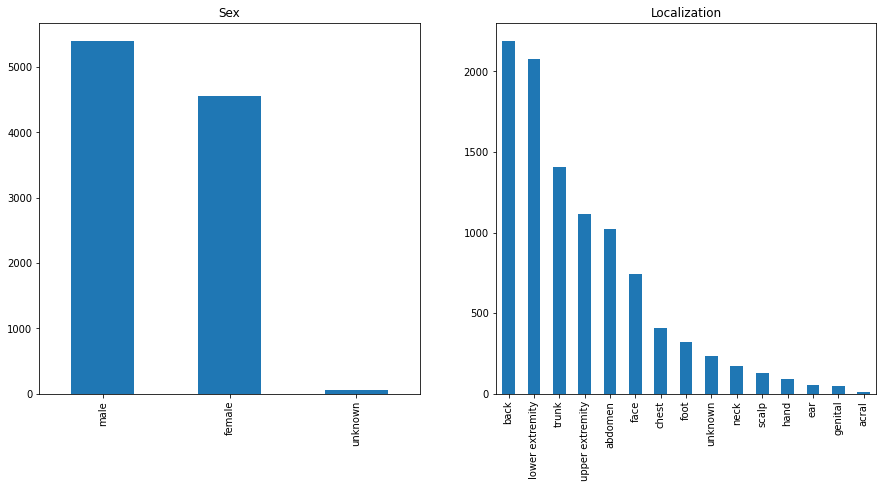

In [31]:
fig =plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
metadata['sex'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Sex')

ax2=fig.add_subplot(222)
metadata['localization'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Localization')

Text(0.5, 1.0, 'Diagnosis')

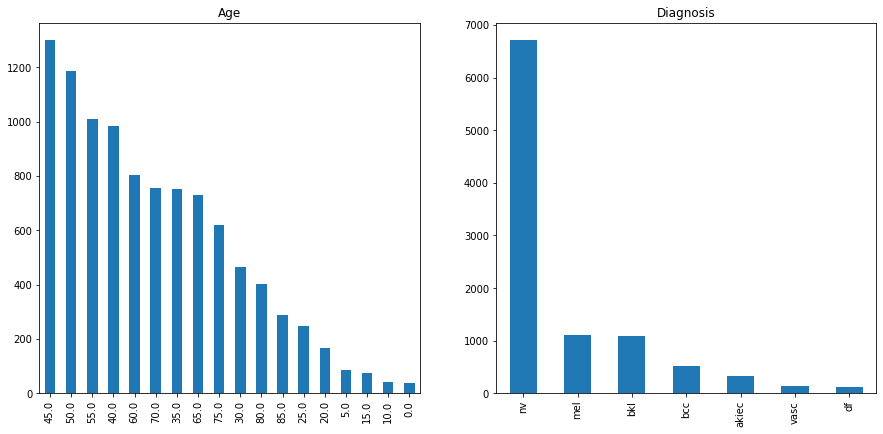

In [32]:
fig =plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
metadata['age'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Age')

ax2=fig.add_subplot(222)
metadata['dx'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Diagnosis')

Correlation

Cross Tabulation of Age and Dx (Skin Lesion)
nv = Melanocytic nevi
mel = Melanoma
bkl = Benign keratosis-like lesions
bcc = Basal cell carcinoma
akiec = Actinic keratosis
vas = Vascular lesions
df = Dermatofibroma

In [33]:
ct = pd.crosstab(index=metadata['age'], columns=metadata['dx'])
print(ct)


dx    akiec  bcc  bkl  df  mel    nv  vasc
age                                       
0.0       0    0    5   0    0    30     4
5.0       0    0    1   0    1    81     3
10.0      0    0    0   0    0    39     2
15.0      0    0    0   0    0    73     4
20.0      0    1    0   0    6   158     4
25.0      0    3    0   2   16   221     5
30.0      1    4    6   4   34   410     5
35.0      0    5   24  12   36   668     8
40.0      9   23   46   9   49   846     3
45.0     10   26   59  14   74  1100    16
50.0     19   27   87  18   96   928    12
55.0     27   25   95  13  142   686    21
60.0     58   35  131   9  106   454    10
65.0     38   79  108  18  133   351     4
70.0     56   85  183   4  166   248    14
75.0     47   76  153   9   91   231    11
80.0     37   73   98   3   85    97    11
85.0     25   52   93   0   76    39     5


In [34]:
ct2 = pd.crosstab(index=metadata['sex'], columns=metadata['dx'])
print(ct2)

dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female     106  197  463  52  424  3237    73
male       221  317  626  63  689  3421    69
unknown      0    0   10   0    0    47     0


In [33]:
from scipy.stats import chi2_contingency
#Sex & Localization
chi2= chi2_contingency(ct2)
print("PValue = " , chi2[1])


PValue =  2.4464388098587195e-17


In [37]:
#Age & DX
chi2_2= chi2_contingency(ct)
print("PValue = " , chi2_2[1])

PValue =  0.0


#### Step 2: Image EDA
We will perform the following analysis on the metadata:
- Average image of each label.
- Principal component analysis (PCA) on each label.

**Average Image**

Here we have made a composite image of each disease category.  The composite is made up of the average pixel value of every image in the category.  The average

Upon visual inspection of these images we can see that there is some unique variation within each image. The dark "blobs" are all different sizes.  They all have unique fading of the edges and all of different intensity of opacity.  As far as modeling is concerned, this is an encouraging that our classifier will be able to find unique patterns for classification. 

In [63]:
akiec_images.shape

(327, 22500)

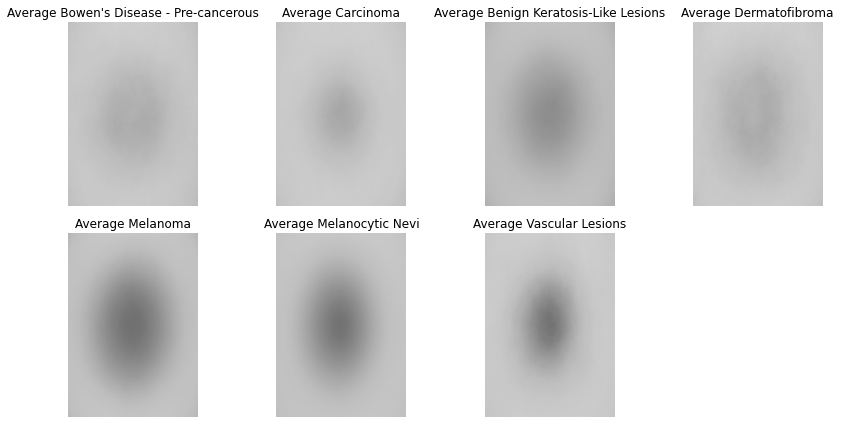

In [79]:
img_dict = {
    "Bowen's Disease - Pre-cancerous": akiec_images, 
    "Carcinoma": bcc_images, 
    "Benign Keratosis-Like Lesions":bkl_images,
    "Dermatofibroma":df_images,
    "Melanoma": mel_images,
    "Melanocytic Nevi": nv_images,
    "Vascular Lesions": vasc_images,
}
find_mean_img(img_dict);

**Principal Component Analysis**
In this section we conducted principal component analysis.  We achieved this by linearly reducing the dimensions of each image by first mean centering all the images then using singular value decomposition to project the data values to a lower dimensional space.  Here we are displaying components with 70% variability.

Below we are displaying eigenimages of our PCA components which are essentially eigenvectors reshaped into an image matrix.  The eigenimages technique works well for this tasks because it reduces the number of dimensions in our data without losing information.  We are then left with images which highlight (by darkness) the most common characteristics within each disease group.  

Summary of the most notable observations:
- Some of the diseases have very unique features.  For example: The melanoma images show very distinct features in the last two images of darkness in the upper and lower regions.  
- Some of the images are showing some similarities as well that may lead to false identification of the disease.  We can see a similar ring pattern within melanocytic nevi, keratosis, and melanoma.
- Some images are also showing high resolution which means that we may not have enough samples within that disease category.

To display these images, we used 70% variability. However, for modeling, we may want to consider using a higher variability settings for better resolution.  

[[171. 170. 166. ... 163. 170. 171.]
 [158. 163. 163. ... 189. 187. 174.]
 [173. 177. 176. ... 184. 185. 183.]
 ...
 [113. 112. 111. ...  99. 104. 103.]
 [118. 120. 128. ... 162. 148. 149.]
 [157. 153. 153. ... 172. 175. 175.]] 0.7
Number of PC in Bowen's Disease - Pre-cancerous: 11


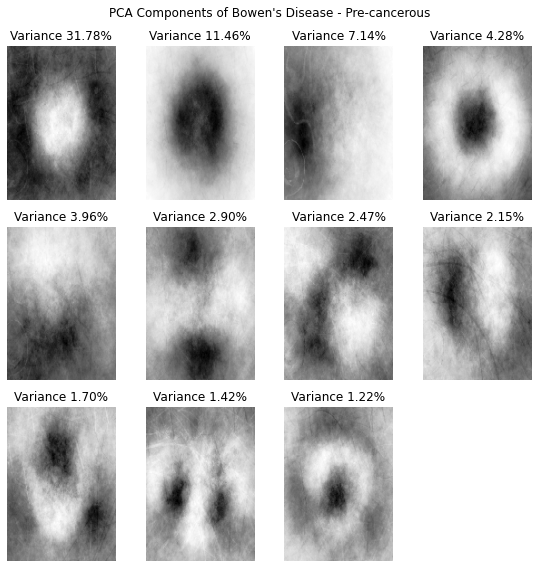

[[160. 165. 178. ... 170. 167. 168.]
 [176. 172. 171. ... 184. 184. 186.]
 [167. 171. 172. ... 156. 159. 158.]
 ...
 [118. 123. 130. ... 154. 148. 152.]
 [ 36.  46.  54. ...  85.  83.  75.]
 [144. 150. 156. ... 170. 170. 169.]] 0.7
Number of PC in Carcinoma: 8


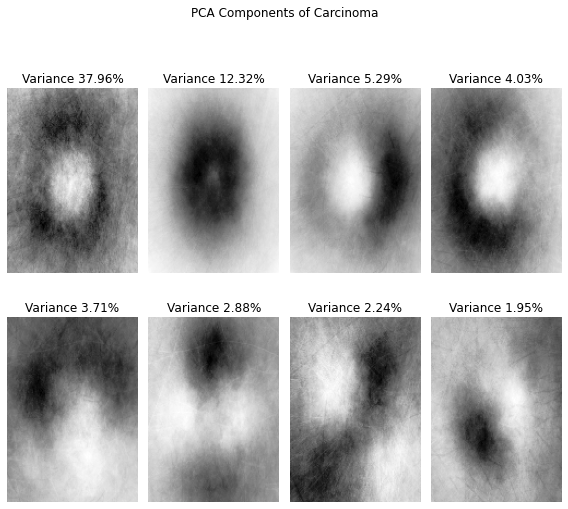

[[171. 173. 179. ... 172. 173. 174.]
 [160. 163. 162. ... 156. 156. 156.]
 [157. 155. 158. ... 139. 141. 136.]
 ...
 [155. 148. 155. ... 129. 132. 124.]
 [122. 127. 134. ... 142. 137. 129.]
 [162. 164. 166. ... 181. 180. 177.]] 0.7
Number of PC in Benign Keratosis-Like Lesions: 7


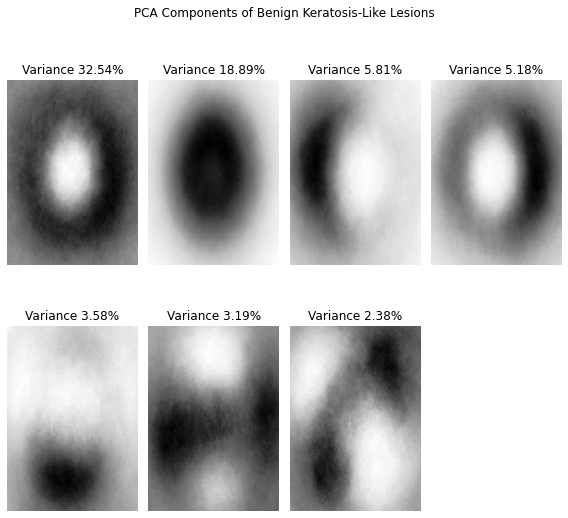

[[191. 188. 190. ... 182. 185. 185.]
 [174. 175. 173. ... 159. 161. 161.]
 [155. 158. 159. ... 151. 159. 165.]
 ...
 [136. 138. 141. ... 136. 134. 131.]
 [137. 137. 138. ... 119. 121. 122.]
 [125. 126. 124. ... 152. 142. 144.]] 0.7
Number of PC in Dermatofibroma: 5


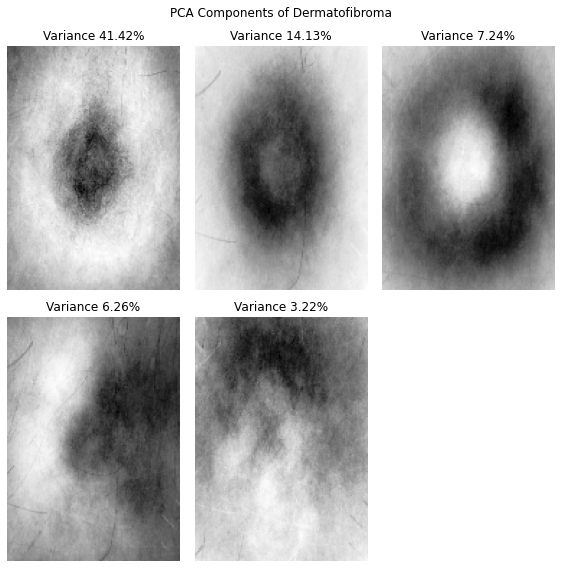

[[178. 182. 184. ... 185. 177. 180.]
 [180. 182. 179. ... 188. 189. 189.]
 [158. 156. 157. ... 121. 117. 117.]
 ...
 [171. 172. 173. ... 172. 169. 175.]
 [127. 124. 119. ... 150. 150. 151.]
 [223. 221. 220. ... 223. 222. 224.]] 0.7
Number of PC in Melanoma: 7


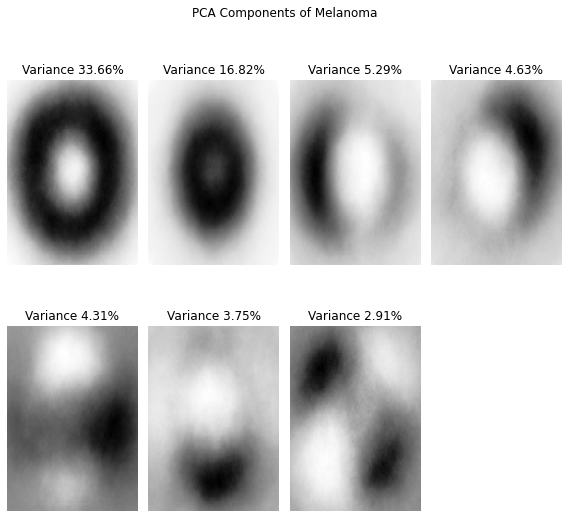

[[149. 153. 151. ... 170. 168. 169.]
 [155. 154. 155. ... 169. 172. 169.]
 [195. 196. 195. ... 137. 139. 151.]
 ...
 [105. 108. 111. ... 120. 117. 109.]
 [111. 112. 111. ... 108. 105. 103.]
 [198. 196. 202. ... 193. 192. 194.]] 0.7
Number of PC in Melanocytic Nevi: 5


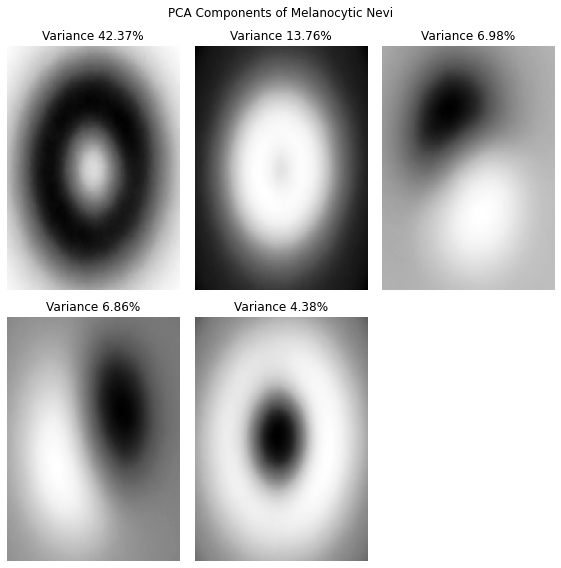

[[149. 153. 154. ... 161. 157. 158.]
 [168. 171. 171. ... 167. 165. 164.]
 [175. 179. 180. ... 174. 173. 172.]
 ...
 [170. 168. 169. ... 174. 173. 174.]
 [195. 190. 193. ... 186. 186. 189.]
 [150. 153. 161. ... 162. 156. 162.]] 0.7
Number of PC in Vascular Lesions: 4


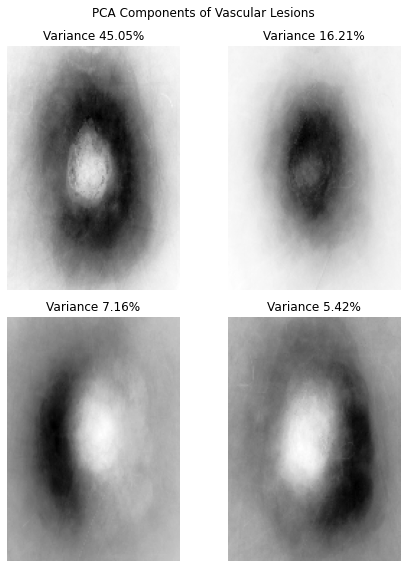

In [80]:
for i in img_dict:
    # print(img_dict[i])
    pca = eigenimages(img_dict[i])
    plot_pca(pca, i)

# 4. Data Processing for Model Ingestion

# 5. Model Creation

# 6. Model Scoring & Evaluation

# 7. Interpretation of Results